## Notes
This notebook is `Zeus` free

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from scipy.integrate import simpson
from scipy.special import spherical_jn, i0
import plotly.graph_objects as go
from tqdm import tqdm

import plotly.io as pio
pio.renderers.default = "iframe"

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [32]:
# Get matter power spectrum from Class
cosmo = Class()
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 1e3}
cosmo.set(params)
cosmo.compute()

In [33]:
z = 0
n_r = 150
k_arr = np.geomspace(0.001, 100, n_r)
pk_arr = np.asarray([cosmo.pk(ki, z) for ki in k_arr])

OmegaM = cosmo.Omega_m()
OmegaL = cosmo.Omega_Lambda()
hubble = cosmo.pars['H0']
# f approximation given by Lahav+ (1991) (Hamilton Eq.(5))
f_0 = OmegaM**(4/7) + (1 + OmegaM / 2) * OmegaL / 70
D_dot = f_0 * hubble

r_arr = np.linspace(0.001, 500, n_r)
r = 0

In [34]:
def integrand_para(r):
    return pk_arr * (spherical_jn(0, k_arr*r) - (2/(k_arr*r)) * spherical_jn(1, k_arr*r))
def integrand_perp(r):
    return pk_arr * spherical_jn(1, k_arr*r) / (k_arr*r)
def integrand_v(r):
    return pk_arr * spherical_jn(0, k_arr*r)

def xi_para(r):
    integrand = integrand_para(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)
def xi_perp(r):
    integrand = integrand_perp(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)
def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)

Text(0.5, 0, '$r\\,[\\mathrm{Mpc}\\,h^{-1}]$')

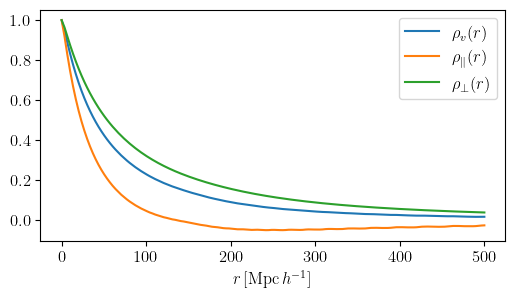

In [35]:
xi_v_arr = np.asarray([xi_v(r) for r in r_arr])
xi_para_arr = np.asarray([xi_para(r) for r in r_arr])
xi_perp_arr = np.asarray([xi_perp(r) for r in r_arr])

vbarsq = xi_v_arr[0] / 3
rho_v = xi_v_arr / 3 / vbarsq
rho_para = xi_para_arr / vbarsq
rho_perp = xi_perp_arr / vbarsq

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(r_arr, rho_v, label=r'$\rho_v(r)$')
ax.plot(r_arr, rho_para, label=r'$\rho_\parallel(r)$')
ax.plot(r_arr, rho_perp, label=r'$\rho_\perp(r)$')
ax.legend()
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')

## PDF definitions

In [36]:
def prefactor_N(vbarsq, rho_para, rho_perp):
    return (2 * np.pi * vbarsq)**3 * np.sqrt(1 - rho_para**2) * (1 - rho_perp**2)

def P_v_v(vbarsq, rho_para, rho_perp, v_1, v_2):
    '''
    Joint PDF of velocities v_1 and v_2.
    6 dimensional input seems like a handful.
    vbarsq is scalar.
    rho_para and rho_perp must have the same length (currently only support 1 dimension).
    v_1 and v_2 are 3D vectors, must have shape (n, 3).
    Not currently used
    '''
    N = prefactor_N(vbarsq, rho_para, rho_perp)

    # Broadcast to shape: (n_r, n_v, 3)
    N_bcast = N[:, np.newaxis, np.newaxis]
    rho_para_bcast = rho_para[:, np.newaxis, np.newaxis]
    rho_perp_bcast = rho_perp[:, np.newaxis, np.newaxis]
    v_1_bcast = v_1[np.newaxis, :, :]
    v_2_bcast = v_2[np.newaxis, :, :]

    v_1_perp = v_1_bcast[:, :, 0:1]
    v_2_perp = v_2_bcast[:, :, 0:1]
    v_1_z = v_1_bcast[:, :, 2]
    v_2_z = v_2_bcast[:, :, 2]

    exponent = - 1 / (2 * vbarsq) * (
                                    (v_1_z**2 + v_2_z**2 - 2 * rho_para_bcast * v_1_z * v_2_z) / (1 - rho_para_bcast**2) + 
                                    (v_1_perp**2 + v_2_perp**2 - 2 * rho_perp_bcast * np.inner(v_1_perp, v_2_perp)) / (1 - rho_perp_bcast**2)
                                    )
    return 1 / N_bcast * np.exp(exponent)

def P_X_Y(X, Y, vbarsq, rho_para, rho_perp, n_points=100):
    '''
    Joint PDF of X=v_1**2 and Y=v_2**2.
    vbarsq is scalar.
    rho_para and rho_perp must have the same length (currently only support 1 dimension)
    '''
    rho_para = np.array([rho_para]) if np.isscalar(rho_para) else np.array(rho_para)
    rho_perp = np.array([rho_perp]) if np.isscalar(rho_perp) else np.array(rho_perp)
    X = np.array([X]) if np.isscalar(X) else np.array(X)
    Y = np.array([Y]) if np.isscalar(Y) else np.array(Y)

    vbarsq = np.full_like(rho_para, vbarsq) # currently limited to scalar value vbarsq

    sqrtX = np.sqrt(X)
    sqrtY = np.sqrt(Y)

    # n_r is the length of r_list, vbarsq, rho_para, and rho_perp
    n_r, n_X, n_Y = len(vbarsq), len(X), len(Y)

    result = np.zeros((n_r, n_X, n_Y))

    # Loop over X and Y (needed due to different integration bounds)
    # But vectorize over r dimension
    for j in tqdm(range(len(X))):
        for k in range(len(Y)):
            v_1_z_arr = np.linspace(-0.999*sqrtX[j], 0.999*sqrtX[j], n_points)
            v_2_z_arr = np.linspace(-0.999*sqrtY[k], 0.999*sqrtY[k], n_points)

            v_1_z_mesh, v_2_z_mesh = np.meshgrid(v_1_z_arr, v_2_z_arr, indexing='ij')
            X_arr = np.full_like(v_1_z_mesh, X[j])
            Y_arr = np.full_like(v_2_z_mesh, Y[k])

            # Broadcast to shape: (n_r, n_points, n_points)
            vbarsq_grid = vbarsq[:, np.newaxis, np.newaxis]
            rho_para_grid = rho_para[:, np.newaxis, np.newaxis]
            rho_perp_grid = rho_perp[:, np.newaxis, np.newaxis]
            v_1_z_grid = v_1_z_mesh[np.newaxis, :, :]
            v_2_z_grid = v_2_z_mesh[np.newaxis, :, :]
            X_grid = X_arr[np.newaxis, :, :]
            Y_grid = Y_arr[np.newaxis, :, :]

            # Compute prefactor
            N = prefactor_N(vbarsq, rho_para, rho_perp)
            prefactor = np.pi**2 / N * np.exp(- (X[j] + Y[k]) / (2 * vbarsq * (1 - rho_perp**2)))

            # Compute integrand
            integrand_exp = - 1 / (2 * vbarsq_grid) * (
                                        (rho_para_grid**2 - rho_perp_grid**2) * (v_1_z_grid**2 + v_2_z_grid**2) / ((1 - rho_para_grid**2) * (1 - rho_perp_grid**2)) - 
                                        2 * rho_para_grid * v_1_z_grid * v_2_z_grid / (1 - rho_para_grid**2)
                                        )
            argument = rho_perp_grid * np.sqrt(X_grid - v_1_z_grid**2) * np.sqrt(Y_grid - v_2_z_grid**2) / (vbarsq_grid * (1 - rho_perp_grid**2))
            integrand_I0 = i0(argument)

            # Integrate
            integral_v2 = simpson(np.exp(integrand_exp) * integrand_I0, x=v_2_z_arr)
            integral_v1_v2 = simpson(integral_v2, x=v_1_z_arr)

            result[:, j, k] = prefactor * integral_v1_v2

    return result

## Plot PDF

In [37]:
X_arr = np.linspace(0.1, 1e6, 30)
Y_arr = np.linspace(0.1, 1e6, 30)

P_X_Y_arr = P_X_Y(X_arr, Y_arr, vbarsq, rho_para, rho_perp)

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:76: RuntimeWarning:

overflow encountered in exp

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:87: RuntimeWarning:

invalid value encountered in multiply

100%|██████████| 30/30 [09:51<00:00, 19.72s/it]


In [38]:
rho_para_temp = rho_para[3]
rho_perp_temp = rho_perp[3]
P_X_Y_arr_temp = P_X_Y(X_arr, Y_arr, vbarsq, rho_para_temp, rho_perp_temp)
simpson(simpson(P_X_Y_arr_temp, x=Y_arr), x=X_arr)

100%|██████████| 30/30 [00:05<00:00,  5.70it/s]


array([0.9608502])

In [39]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == n_r-1),  # Only show the last one initially
            name=f'r = {r_arr[i]:.1f} Mpc/h',
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_arr[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Joint PDF for velocity² with anisotropic correlations',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()

### Difference between isotropic and anisotropic

In [40]:
P_X_Y_iso_arr = P_X_Y(X_arr, Y_arr, vbarsq, rho_v, rho_v)
P_X_Y_diff_arr = P_X_Y_arr - P_X_Y_iso_arr

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:76: RuntimeWarning:

divide by zero encountered in divide

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:76: RuntimeWarning:

invalid value encountered in multiply

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:80: RuntimeWarning:

invalid value encountered in divide

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:81: RuntimeWarning:

divide by zero encountered in divide

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_19636/512126536.py:83: RuntimeWarning:

divide by zero encountered in divide

100%|██████████| 30/30 [10:37<00:00, 21.24s/it]


In [41]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_diff_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_iso_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == 0),  # Only show the first one initially
            name=f'r = {r_arr[i]:.1f} Mpc/h'
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_arr[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Difference between isotropic and anisotropic P(X, Y)',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()

In [42]:
P_X_Y_frac_arr = P_X_Y_diff_arr / P_X_Y_iso_arr

In [43]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_frac_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_frac_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == 0),  # Only show the first one initially
            name=f'r = {r_arr[i]:.1f} Mpc/h'
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_arr[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Fractional difference between isotropic and anisotropic P(X, Y)',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()